Домашнее задание по теме «Иерархическая кластеризация»

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

from joblib import dump

Загружаем данные

In [2]:
train_df=pd.read_csv('penguins.csv')

In [3]:
pd.options.display.float_format = '{:,.2f}'.format
train_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.70,181.00,"3,750.00",MALE
1,39.50,17.40,186.00,"3,800.00",FEMALE
2,40.30,18.00,195.00,"3,250.00",FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.70,19.30,193.00,"3,450.00",FEMALE


In [4]:
train_df.info(memory_usage=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


Можно заметить, что в таблице есть пропуски. Оставим их для EDA, а для обучения модели заполним их.

In [5]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.58
culmen_depth_mm,0.58
flipper_length_mm,0.58
body_mass_g,0.58
sex,2.62


Выделяем категориальные и числовые столбцы и создаем подтаблицы для EDA.

In [6]:
category_col = train_df.select_dtypes(include=['object']).columns.tolist()
category_col

['sex']

In [7]:
train_df_cat = train_df[category_col]
number_col = train_df.select_dtypes(include=['number']).columns.tolist()
train_df_num = train_df[number_col]

Заполнение пропусков

In [8]:
train_df = train_df.apply(lambda x: x.fillna(x.mode()[0]))

In [9]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.00
culmen_depth_mm,0.00
flipper_length_mm,0.00
body_mass_g,0.00
sex,0.00


Для кодирования категориальных переменных будем использовать TargetOrdinalEncoding

# EDA

Для числовых столбцов:

In [64]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_num.isnull().sum() * 100 / len(train_df_num.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.58
culmen_depth_mm,0.58
flipper_length_mm,0.58
body_mass_g,0.58


In [65]:
#Находим максимальные и минимальные значения
min_max_df = pd.DataFrame({'Максимальное значение': train_df_num.max(), 'Минимальное значение': train_df_num.min()})

min_max_df

,Максимальное значение,Минимальное значение
culmen_length_mm,59.60,32.10
culmen_depth_mm,21.50,13.10
flipper_length_mm,"5,000.00",-132.00
body_mass_g,"6,300.00","2,700.00"


In [66]:
#Находим средние значения
mean_df = pd.DataFrame({'Среднее значение': train_df_num.mean()})

mean_df

,Среднее значение
culmen_length_mm,43.92
culmen_depth_mm,17.15
flipper_length_mm,214.01
body_mass_g,"4,201.75"


In [67]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df_num.median()})

median_df

,Медиана
culmen_length_mm,44.45
culmen_depth_mm,17.30
flipper_length_mm,197.00
body_mass_g,"4,050.00"


In [68]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df_num.var()})

var_df

,Диспрерсия
culmen_length_mm,29.81
culmen_depth_mm,3.90
flipper_length_mm,"67,890.50"
body_mass_g,"643,131.08"


In [69]:
#Находим квантиль 0.1 и 0.9
quantile_df = pd.DataFrame({'Квантиль 0.1': train_df_num.quantile(0.1), 'Квантиль 0.9': train_df_num.quantile(0.9)})

quantile_df

,Квантиль 0.1,Квантиль 0.9
culmen_length_mm,36.60,50.80
culmen_depth_mm,14.30,19.50
flipper_length_mm,185.00,221.00
body_mass_g,"3,300.00","5,400.00"


In [70]:
#Находим квартиль 1 и 3
quartile_df = pd.DataFrame({'Квартиль 1': train_df_num.quantile(0.25), 'Квартиль 3': train_df_num.quantile(0.75)})

quartile_df

,Квартиль 1,Квартиль 3
culmen_length_mm,39.23,48.50
culmen_depth_mm,15.60,18.70
flipper_length_mm,190.00,213.75
body_mass_g,"3,550.00","4,750.00"


Для категориальных столбцов:

In [71]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_cat.isnull().sum() * 100 / len(train_df_cat.index)
missing_category_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_category_value_df

,Незаполнено столбце %
sex,2.62


In [72]:
#Находим кол-во уникальных значений
unique_df = pd.DataFrame({'Уникальных значений в столбце': train_df_cat.nunique()})
unique_df

,Уникальных значений в столбце
sex,3


Нужно проверить какие значения в столбце sex.

In [73]:
#Находим моду столбцов
mode_df =  pd.DataFrame({'Мода в столбце':train_df_cat.mode().loc[0]})
mode_df

,Мода в столбце
sex,MALE


# Обработка данных

In [10]:
train_df_cat.value_counts()

sex   
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

Удаляем строчку с точкой 

In [11]:
train_df = train_df[train_df['sex'] != '.']
train_df['sex'].value_counts()

sex
MALE      178
FEMALE    165
Name: count, dtype: int64

Можно заметить несколько скачков в графике. Посмотрим на распределение данных во всей таблице

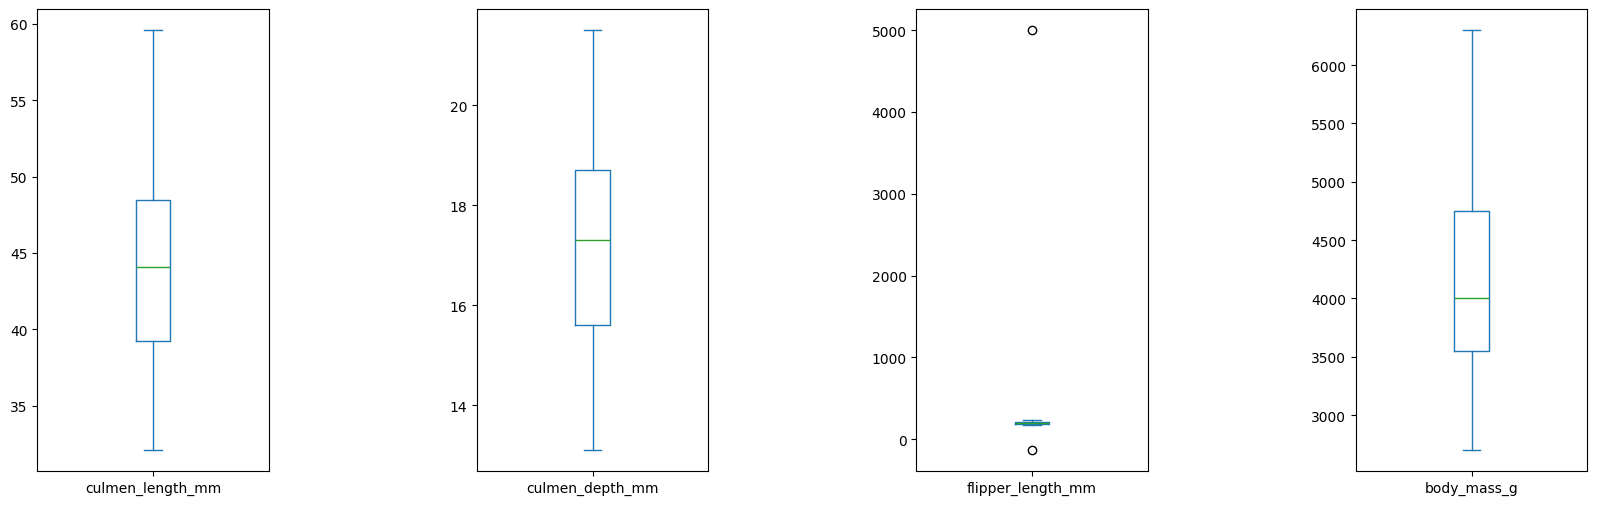

In [12]:
train_df.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

В столбце flipper_length_mm можно заметить выбросы. Избавимся от них

In [13]:
def RemoveOutliers(df, column):
    # убираем выбросы
    Q3 = np.quantile(df[column], 0.75, axis=0)
    Q1 = np.quantile(df[column], 0.25, axis=0)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df[column] = np.where((df[column] > upper), upper, df[column])
    df[column] = np.where((df[column] < lower), lower, df[column])
    return df

In [14]:
for col in ['flipper_length_mm']:
    train_df = RemoveOutliers(train_df, col)

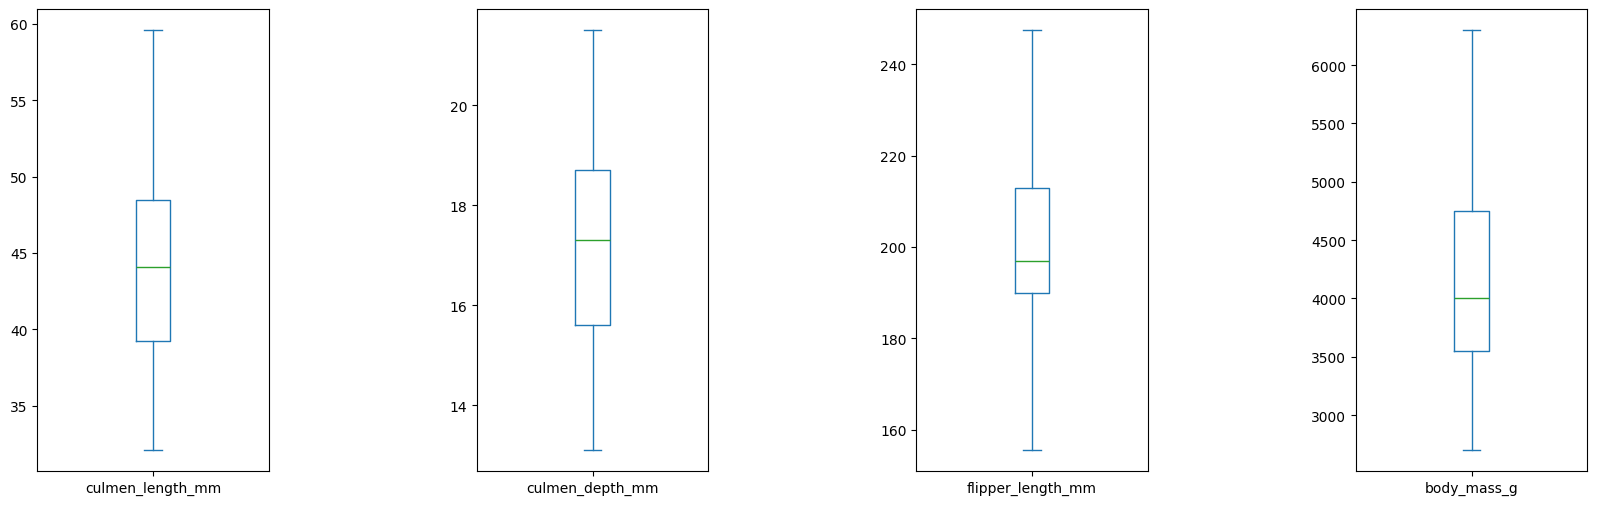

In [15]:
train_df.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

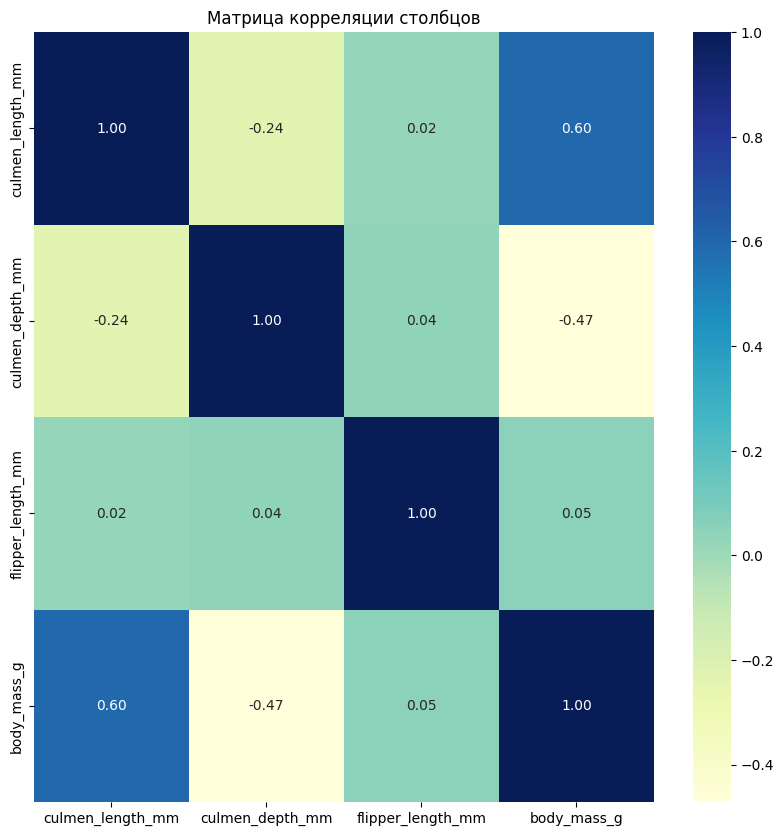

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(train_df_num.corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Матрица корреляции столбцов")
plt.show()

Нет необходимости какой-либо из столбцов удалять.

# Подготовка датасета

Закодируем категориальные переменные

In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
sex = encoder.fit_transform(train_df['sex'])
encoded_df = train_df.drop("sex", axis=1)
encoded_df['sex'] = sex
encoded_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.70,181.00,"3,750.00",1
1,39.50,17.40,186.00,"3,800.00",0
2,40.30,18.00,195.00,"3,250.00",0
3,41.10,17.00,190.00,"3,800.00",1
4,36.70,19.30,193.00,"3,450.00",0
...,...,...,...,...,...
339,41.10,17.00,190.00,"3,800.00",1
340,46.80,14.30,215.00,"4,850.00",0
341,50.40,15.70,222.00,"5,750.00",1
342,45.20,14.80,212.00,"5,200.00",0


In [17]:
encoded_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   343 non-null    float64
 1   culmen_depth_mm    343 non-null    float64
 2   flipper_length_mm  343 non-null    float64
 3   body_mass_g        343 non-null    float64
 4   sex                343 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 16.1 KB


Нормализируем данные

In [18]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
df_scaled = pd.DataFrame(Scaler.fit_transform(encoded_df), columns=encoded_df.columns)
df_scaled

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.88,0.79,-1.37,-0.56,0.96
1,-0.81,0.12,-1.03,-0.50,-1.04
2,-0.66,0.43,-0.41,-1.19,-1.04
3,-0.51,-0.08,-0.75,-0.50,0.96
4,-1.32,1.09,-0.54,-0.94,-1.04
...,...,...,...,...,...
338,-0.51,-0.08,-0.75,-0.50,0.96
339,0.53,-1.45,0.98,0.82,-1.04
340,1.19,-0.74,1.46,1.94,0.96
341,0.24,-1.20,0.77,1.25,-1.04


Уменьшим размерность датафрейма.

In [19]:
int_cols = df_scaled.select_dtypes('int').columns

float_cols = df_scaled.select_dtypes('float').columns
for col in int_cols:
    df_scaled[col] = pd.to_numeric(df_scaled[col], downcast='integer')
for col in float_cols:
    df_scaled[col] = pd.to_numeric(df_scaled[col], downcast='float')

In [20]:
df_scaled.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   343 non-null    float32
 1   culmen_depth_mm    343 non-null    float32
 2   flipper_length_mm  343 non-null    float32
 3   body_mass_g        343 non-null    float32
 4   sex                343 non-null    float32
dtypes: float32(5)
memory usage: 6.8 KB


# AgglomerativeClustering с подбором гиперпараметров в цикле

In [73]:
RAND_STATE = 42

Снизим размерность данных для удобства.

In [74]:
pca = PCA(n_components=2)
reduced_data_pca = pd.DataFrame(pca.fit_transform(df_scaled), columns= ['Признак 1', 'Признак 2'])
reduced_data_pca

,Признак 1,Признак 2
0,-1.56,1.16
1,-1.49,-0.76
2,-1.56,-0.64
3,-0.71,0.61
4,-2.03,-0.30
...,...,...
338,-0.71,0.61
339,1.52,-1.65
340,2.91,0.42
341,1.42,-1.49


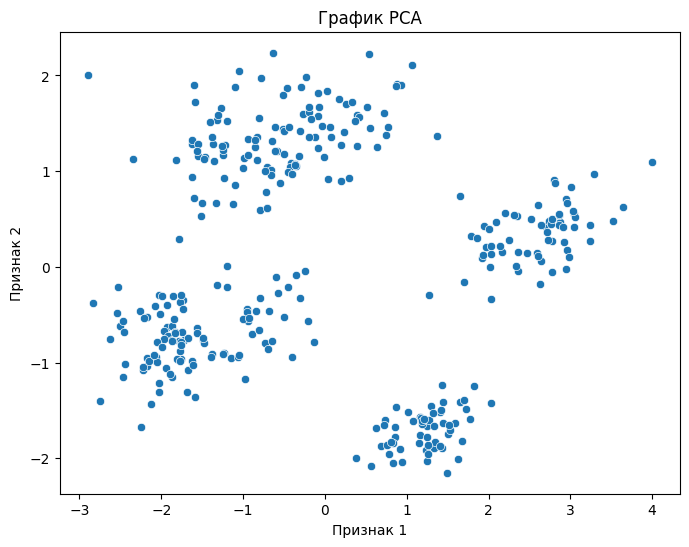

In [91]:
# Построение графика
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data_pca['Признак 1'],
                        y=reduced_data_pca['Признак 2'])
plt.title('График PCA')
plt.show()

In [64]:
agg_cluster_score = 0
best_agg_cluster = []

linkage_list = ['complete', 'average', 'single']

for k in range(2,10):
    for metric in ['l1', 'l2', 'manhattan', 'cosine', 'euclidean']:
        if metric == 'euclidean':
            linkage_list.append('ward')
        for link in linkage_list:
            agg_cluster = AgglomerativeClustering(n_clusters=k, metric=metric, linkage=link)
            cluster_silhouette_score = silhouette_score(reduced_data_pca, agg_cluster.fit_predict(reduced_data_pca), metric=metric, random_state=RAND_STATE)
            if cluster_silhouette_score > agg_cluster_score:
                agg_cluster_score = cluster_silhouette_score
                best_agg_cluster = agg_cluster
        if metric == 'euclidean':
            linkage_list.pop()
        

print("Лучший силуэт: ", agg_cluster_score)

print("Параметры модели с лучшим силуэтом: ", best_agg_cluster.get_params())

Лучший силуэт:  0.8701262
Параметры модели с лучшим силуэтом:  {'compute_distances': False, 'compute_full_tree': 'auto', 'connectivity': None, 'distance_threshold': None, 'linkage': 'complete', 'memory': None, 'metric': 'cosine', 'n_clusters': 5}


In [65]:
best_agg_cluster_params = best_agg_cluster.get_params()

In [66]:
best_agg_cluster

AgglomerativeClustering(linkage='complete', metric='cosine', n_clusters=5)

In [67]:
labels  = best_agg_cluster.fit_predict(reduced_data_pca)
labels

array([2, 0, 0, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2,
       0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1,
       0, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 2, 0,
       2, 0, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 1,
       0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2,
       0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 0, 2, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       3, 4, 3, 4, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 4, 3,
       3, 4, 3, 4, 4, 4, 3, 4, 4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       4, 3, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4,
       4, 4, 3, 4, 3, 4, 4, 3, 3, 4, 3, 4, 3, 4, 3,

Text(0.5, 1.0, 'n_clusters = 5')

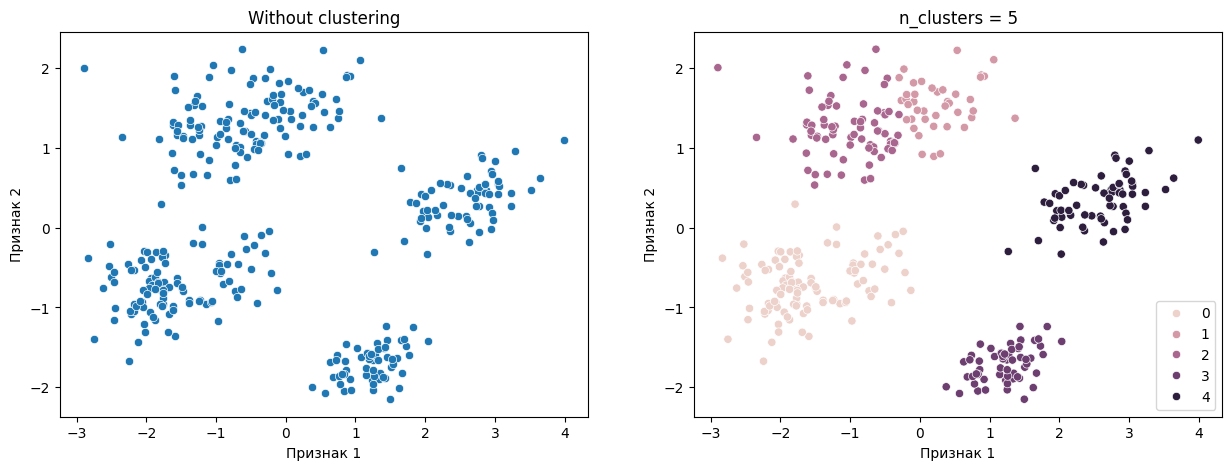

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.scatterplot(
    ax=axes[0], data=reduced_data_pca, x='Признак 1', y='Признак 2'
).set_title("Without clustering")
sns.scatterplot(
    ax=axes[1],
    data=reduced_data_pca,
    x='Признак 1',
    y='Признак 2',
    hue=labels,
).set_title("n_clusters = 5")

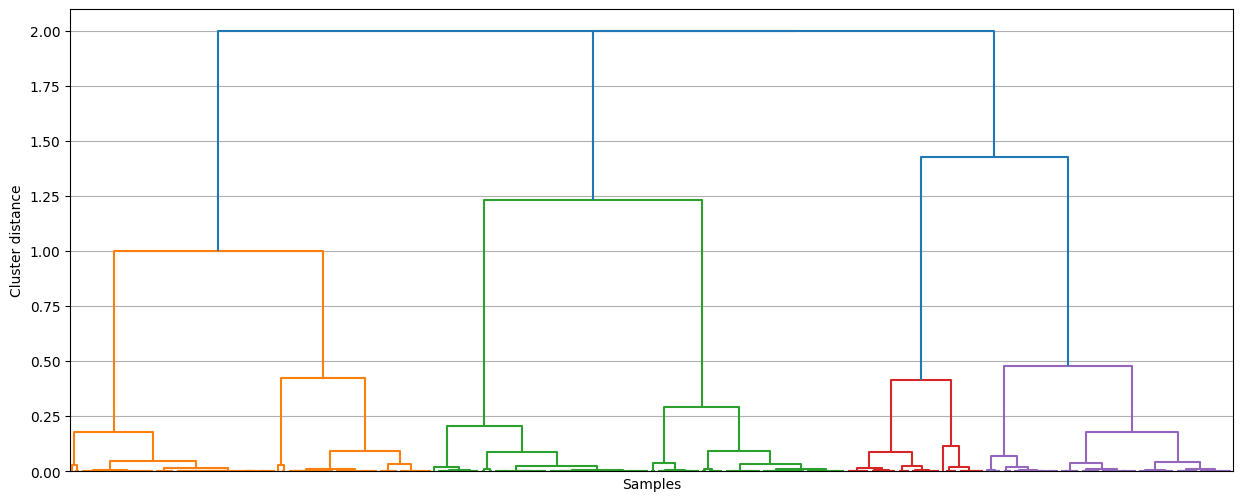

In [69]:
from scipy.cluster.hierarchy import dendrogram, linkage

clusters = linkage(reduced_data_pca, method=best_agg_cluster_params['linkage'], metric=best_agg_cluster_params['metric'])

plt.figure(figsize=(15, 6))
dendrogram = dendrogram(clusters)

plt.xticks([])
plt.xlabel("Samples")
plt.ylabel("Cluster distance")
plt.grid()

Данные делятся на 5 кластеров. Лучший силует равен 0.8701262. Это означает, что кластеризация данных в данном случае высокого качества.

# Сохраните модель в файл joblib

In [70]:
dump(best_agg_cluster, 'best_agg_cluster.joblib')

['best_agg_cluster.joblib']

# AgglomerativeClustering с целевым признаком sex

In [45]:
X = df_scaled.drop('sex', axis=1)
y = sex

Снизим размерность данных для удобства.

In [71]:
pca = PCA(n_components=2)
reduced_data_pca_X = pd.DataFrame(pca.fit_transform(X), columns= ['Признак 1', 'Признак 2'])
reduced_data_pca_X

,Признак 1,Признак 2
0,-1.81,0.05
1,-1.28,-0.43
2,-1.36,-0.14
3,-0.91,-0.41
4,-1.87,0.02
...,...,...
338,-0.91,-0.41
339,1.83,-0.78
340,2.75,0.28
341,1.72,-0.71


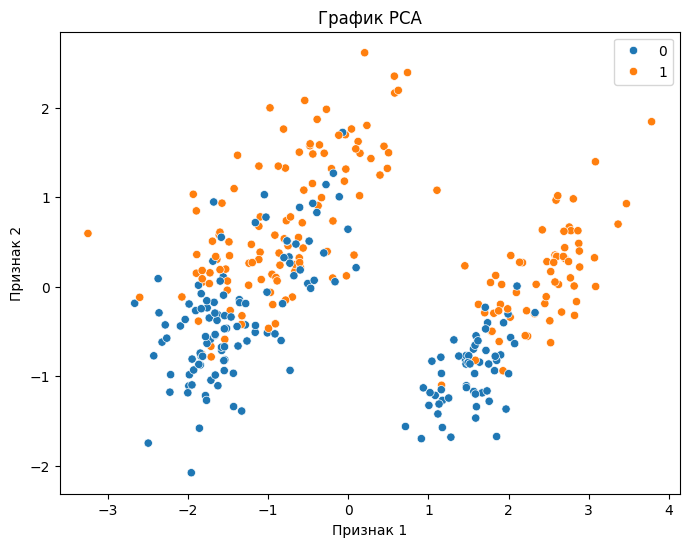

In [72]:
# Построение графика
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data_pca_X['Признак 1'],
                        y=reduced_data_pca_X['Признак 2'], hue=sex)
plt.title('График PCA')
plt.show()

AgglomerativeClustering с подбором гиперпараметров в цикле

In [75]:
agg_cluster_score = 0
best_agg_cluster = []

linkage_list = ['complete', 'average', 'single']

for k in range(2,10):
    for metric in ['l1', 'l2', 'manhattan', 'cosine', 'euclidean']:
        if metric == 'euclidean':
            linkage_list.append('ward')
        for link in linkage_list:
            agg_cluster = AgglomerativeClustering(n_clusters=k, metric=metric, linkage=link)
            cluster_silhouette_score = silhouette_score(reduced_data_pca_X, agg_cluster.fit_predict(reduced_data_pca_X), metric=metric, random_state=RAND_STATE)
            if cluster_silhouette_score > agg_cluster_score:
                agg_cluster_score = cluster_silhouette_score
                best_agg_cluster = agg_cluster
        if metric == 'euclidean':
            linkage_list.pop()
        

print("Лучший силуэт: ", agg_cluster_score)

print("Параметры модели с лучшим силуэтом: ", best_agg_cluster.get_params())

Лучший силуэт:  0.8197701
Параметры модели с лучшим силуэтом:  {'compute_distances': False, 'compute_full_tree': 'auto', 'connectivity': None, 'distance_threshold': None, 'linkage': 'average', 'memory': None, 'metric': 'cosine', 'n_clusters': 3}


В подборе выявилось оптимальным кол-вом кластэров = 3. Но в нашим случае снизим его до 2.

In [76]:
agg_cluster_score = 0
best_agg_cluster = []

linkage_list = ['complete', 'average', 'single']
k = 2
for metric in ['l1', 'l2', 'manhattan', 'cosine', 'euclidean']:
    if metric == 'euclidean':
        linkage_list.append('ward')
    for link in linkage_list:
        agg_cluster = AgglomerativeClustering(n_clusters=k, metric=metric, linkage=link)
        cluster_silhouette_score = silhouette_score(reduced_data_pca_X, agg_cluster.fit_predict(reduced_data_pca_X), metric=metric, random_state=RAND_STATE)
        if cluster_silhouette_score > agg_cluster_score:
            agg_cluster_score = cluster_silhouette_score
            best_agg_cluster = agg_cluster
    if metric == 'euclidean':
        linkage_list.pop()
        
print("Лучший силуэт: ", agg_cluster_score)

print("Параметры модели с лучшим силуэтом: ", best_agg_cluster.get_params())

Лучший силуэт:  0.7850799
Параметры модели с лучшим силуэтом:  {'compute_distances': False, 'compute_full_tree': 'auto', 'connectivity': None, 'distance_threshold': None, 'linkage': 'single', 'memory': None, 'metric': 'cosine', 'n_clusters': 2}


In [77]:
best_agg_cluster_params = best_agg_cluster.get_params()

In [78]:
best_agg_cluster

AgglomerativeClustering(linkage='single', metric='cosine')

Предсказаное распределение на кластеры

In [79]:
labels  = best_agg_cluster.fit_predict(reduced_data_pca_X)
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Text(0.5, 1.0, 'n_clusters = 2')

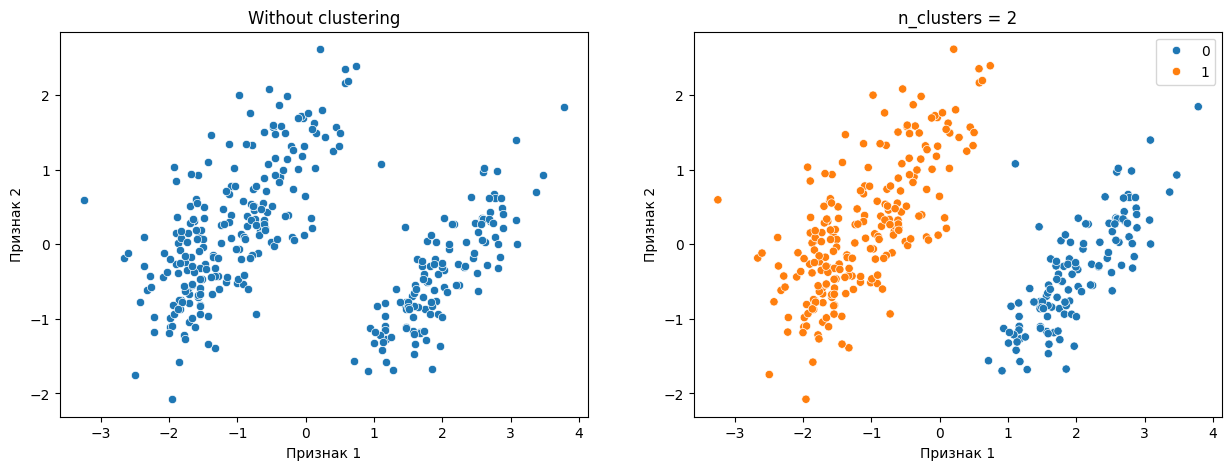

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.scatterplot(
    ax=axes[0], data=reduced_data_pca_X, x='Признак 1', y='Признак 2'
).set_title("Without clustering")
sns.scatterplot(
    ax=axes[1],
    data=reduced_data_pca_X,
    x='Признак 1',
    y='Признак 2',
    hue=labels,
).set_title("n_clusters = 2")

Оценка adjusted_rand_score для 2-х кластеров

In [81]:
print("Оценка качества кластеризации (adjusted_rand_score): ", adjusted_rand_score(y, labels))

Оценка качества кластеризации (adjusted_rand_score):  -0.002800493934610428


Качество кластеризации плохое. Модель не смогла правильно кластеризировать данные c целевым признаком sex.

# DBSCAN

In [92]:
DBSCAN_score = 0
best_DBSCAN = []

for eps in np.arange(0.05, 1.5,0.05):
    for min_samples in np.arange(2,100, 1):
        DB_scan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = DB_scan.fit_predict(reduced_data_pca)
        if len(np.unique(labels)) > 1:
            silhouette_score_DBSCAN = silhouette_score(reduced_data_pca, labels)
            if silhouette_score_DBSCAN > DBSCAN_score:
                DBSCAN_score = silhouette_score_DBSCAN
                best_DBSCAN = DB_scan

print("Лучший силуэт: ", DBSCAN_score)

print("Параметры модели с лучшим силуэтом: ", best_DBSCAN.get_params())

Лучший силуэт:  0.62859404
Параметры модели с лучшим силуэтом:  {'algorithm': 'auto', 'eps': np.float64(0.6500000000000001), 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': np.int64(15), 'n_jobs': None, 'p': None}


In [93]:
best_DBSCAN

DBSCAN(eps=np.float64(0.6500000000000001), min_samples=np.int64(15))

Силует AgglomerativeClustering равен 0.8701262, а DBSCAN - 0.62859404. Качество кластеризации с DBSCAN немного меньше, чем с AgglomerativeClustering. Это означает , что в этом случае AgglomerativeClustering работает лучше.

Text(0.5, 1.0, 'DBSCAN')

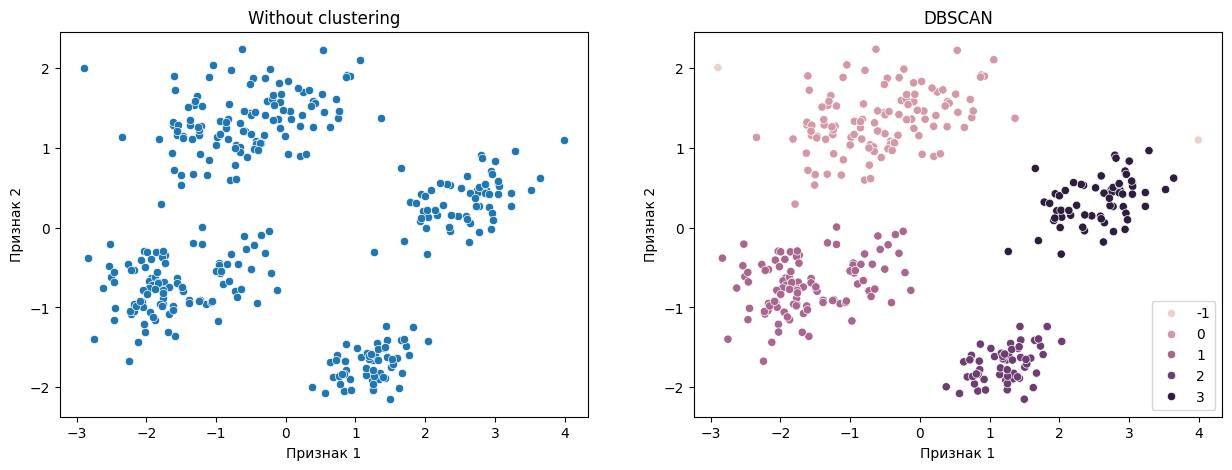

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.scatterplot(
    ax=axes[0], data=reduced_data_pca, x='Признак 1', y='Признак 2'
).set_title("Without clustering")
sns.scatterplot(
    ax=axes[1],
    data=reduced_data_pca,
    x='Признак 1',
    y='Признак 2',
    hue=best_DBSCAN.labels_,
).set_title("DBSCAN")